# Waheeb Algabri

Final project

# Introduction

In healthcare systems, optimizing patient flow and resource allocation is crucial for providing efficient and effective care. Simulation modeling allows us to analyze and evaluate different scenarios to improve the performance of medical facilities. In this simulation, we explore the dynamics of patient arrivals, triage, and treatment in an outpatient setting. By simulating the operations of a medical facility over a specified time period, we can assess key performance metrics, such as waiting time, treatment time, and resource utilization.

# Problem and Significance

Problem: The emergency room (ER) is a critical part of a healthcare facility where patients with varying degrees of illness or injury seek immediate medical attention. However, managing the flow of patients in the ER can be challenging, particularly during peak hours or when resources are limited. It is essential to ensure that patients are efficiently triaged, treated, and allocated appropriate medical resources (doctors and nurses) based on the severity of their condition.

Significance: The project's simulation-based optimization of resource allocation and patient flow in an emergency room has the potential to enhance efficiency, improve patient outcomes, and enable data-driven decision making for healthcare administrators.


# Flow Chart model

The flowchart of the process is shown below:

In [209]:
#from IPython.display import Image
# Image(filename = "flowchart.png", width=600, height=700)

# Simulate the process for the appropriate number of iterations

In [210]:
# Import required libraries
!pip install simpy
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Patient 1 checked-in at 8.577641373078212
Patient 1 triaged at 17.55432306335093
Patient 1 sees a doctor at 17.55432306335093
Patient 2 checked-in at 25.114453492049883
Patient 1 treated by doctor at 32.554323063350935
Patient 3 checked-in at 32.87656568709988
Patient 4 checked-in at 34.647765371694724
Patient 2 triaged at 36.12348493191093
Patient 2 sees a nurse at 36.12348493191093
Patient 5 checked-in at 36.8645589161229
Patient 3 triaged at 37.703447594737526
Patient 3 sees a nurse at 37.703447594737526
Patient 4 triaged at 40.58215608714041
Patient 4 sees a doctor at 40.58215608714041
Patient 6 checked-in at 41.633161187156944
Patient 5 triaged at 45.9218303791782
Patient 2 treated by nurse at 46.12348493191093
Patient 5 sees a nurse at 46.12348493191093
Patient 7 checked-in at 47.56590067523104
Patient 3 treated by nurse at 47.703447594737526
Patient 6 triaged at 47.89829748556199
Patient 6 sees a nurse at 47.89829748556199
Patient 7 triaged at 52.333289144720936
Patient 7 sees a

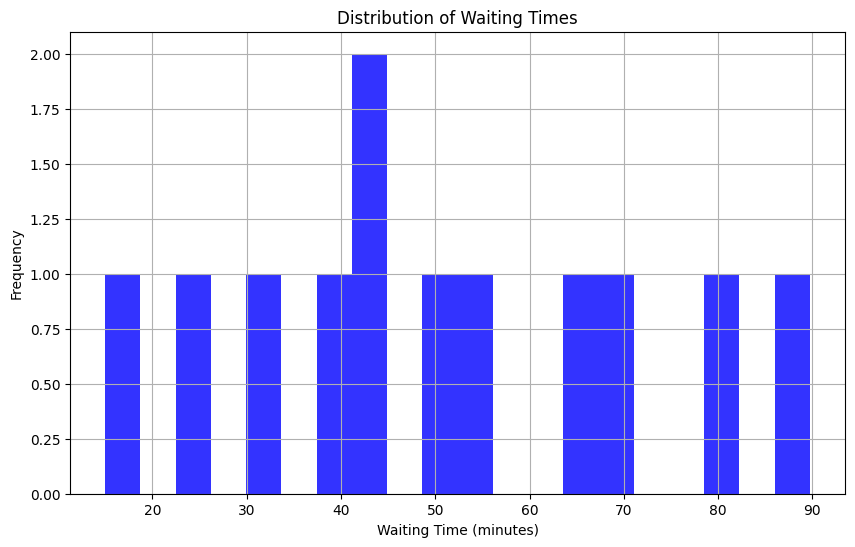

In [211]:
# Constants
MEAN_INTERARRIVAL = 10
CHECKIN_MIN = 6
CHECKIN_MAX = 12
TRIAGE_MIN = 3
TRIAGE_MAX = 15
TRIAGE_MODE = 5
CRITICAL_PROB = 0.4

# Global variables
num_doctors = 2

# Data collection
results = []
utilization_doctors = []
utilization_nurses = []

# Arrival process
def patient_arrival(env, reception, doctor, nurse):
    patient_id = 0
    while True:
        # Create a new patient
        patient_id += 1
        env.process(patient_process(env, patient_id, reception, doctor, nurse))

        # Sample time until next arrival
        interarrival_time = random.expovariate(1.0 / MEAN_INTERARRIVAL)
        yield env.timeout(interarrival_time)

# Patient process
def patient_process(env, patient_id, reception, doctor, nurse):
    global results

    # Check-in
    checkin_time = random.uniform(CHECKIN_MIN, CHECKIN_MAX)
    yield env.timeout(checkin_time)
    print(f"Patient {patient_id} checked-in at {env.now}")
    arrival_time = env.now

    # Triage
    triage_time = random.triangular(TRIAGE_MIN, TRIAGE_MAX, TRIAGE_MODE)
    yield env.timeout(triage_time)
    print(f"Patient {patient_id} triaged at {env.now}")
    token_time = env.now

    # Check critical condition
    critical = random.random() < CRITICAL_PROB

    # Request doctor/nurse
    if critical:
        with doctor.request() as req:
            yield req
            print(f"Patient {patient_id} sees a doctor at {env.now}")
            yield env.timeout(15)  # Treatment time for critical patients
            print(f"Patient {patient_id} treated by doctor at {env.now}")
            treatment_time = 15
    else:
        with nurse.request() as req:
            yield req
            print(f"Patient {patient_id} sees a nurse at {env.now}")
            yield env.timeout(10)  # Treatment time for non-critical patients
            print(f"Patient {patient_id} treated by nurse at {env.now}")
            treatment_time = 10

    # Calculate waiting time and treatment time
    waiting_time = env.now - (checkin_time + triage_time)

    # Record the results
    result = {
        'Patient ID': patient_id,
        'Service': 'Doctor' if critical else 'Nurse',
        'Arrival Time': arrival_time,
        'Token Time': token_time,
        'Service Start Time': env.now - treatment_time,
        'Service Stop Time': env.now,
        'Token Time (Secs)': token_time * 60,
        'Service Time (Mins)': treatment_time,
        'Wait Time (Mins)': waiting_time
    }
    results.append(result)

# Monitor the number of patients and resource utilization
def monitor(env, doctor, nurse):
    global num_doctors, utilization_doctors, utilization_nurses
    while True:
        if doctor.count == num_doctors and doctor.queue:
            num_doctors += 1
            print(f"Additional doctor summoned at {env.now}. Total doctors: {num_doctors}")
        elif num_doctors > 2 and doctor.count == 0 and not doctor.queue:
            num_doctors -= 1
            print(f"Doctor dismissed at {env.now}. Total doctors: {num_doctors}")

        utilization_doctors.append(doctor.count / num_doctors)
        utilization_nurses.append(nurse.count / 2)

        yield env.timeout(1)

# Set up simulation
env = simpy.Environment()

# Resources
reception = simpy.Resource(env, capacity=3)
doctor = simpy.Resource(env, capacity=num_doctors)
nurse = simpy.Resource(env, capacity=2)

# Start processes
env.process(patient_arrival(env, reception, doctor, nurse))
env.process(monitor(env, doctor, nurse))

# Run simulation
env.run(until=100)  # Run for 1 hour and 40 minutes (100 minutes)

# Create a DataFrame from the collected results
df = pd.DataFrame(results, columns=['Patient ID', 'Service', 'Arrival Time', 'Token Time',
                                    'Service Start Time', 'Service Stop Time', 'Token Time (Secs)',
                                    'Service Time (Mins)', 'Wait Time (Mins)'])

# Performance metric calculation
avg_waiting_time = df['Wait Time (Mins)'].mean()
avg_treatment_time = df['Service Time (Mins)'].mean()
doctor_utilization = np.mean(utilization_doctors)
nurse_utilization = np.mean(utilization_nurses)


# Print performance metrics
print(f"Average waiting time: {avg_waiting_time:.2f} minutes")
print(f"Average treatment time: {avg_treatment_time:.2f} minutes")
print(f"Doctor utilization: {doctor_utilization:.2%}")
print(f"Nurse utilization: {nurse_utilization:.2%}")

# Data visualization
plt.figure(figsize=(10, 6))
plt.hist(df['Wait Time (Mins)'], bins=20, alpha=0.8, color='blue')
plt.xlabel('Waiting Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Waiting Times')
plt.grid(True)
plt.show()

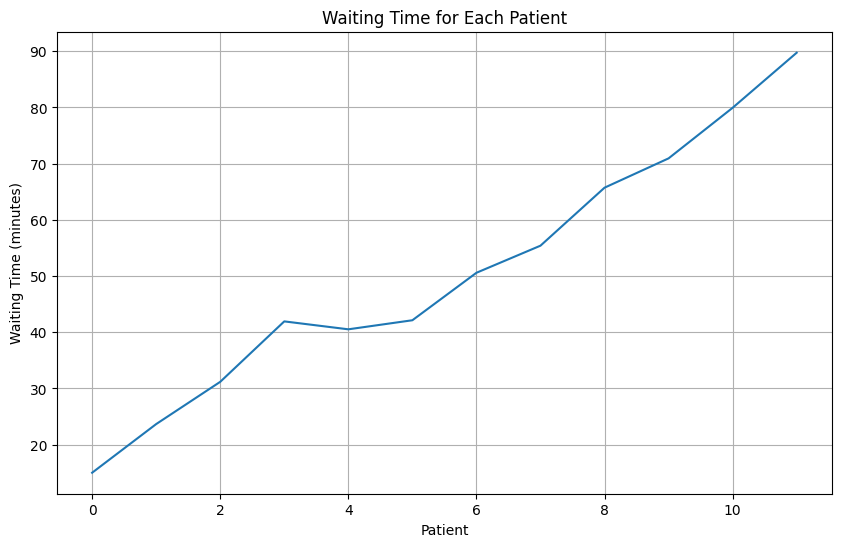

Simulation Report:

Average waiting time: 50.56 minutes



In [212]:
# Calculate average waiting time
avg_waiting_time = df['Wait Time (Mins)'].mean()

# Plot waiting time over time
plt.figure(figsize=(10, 6))
plt.plot(df['Wait Time (Mins)'])
plt.xlabel('Patient')
plt.ylabel('Waiting Time (minutes)')
plt.title('Waiting Time for Each Patient')
plt.grid(True)
plt.show()

# Print simulation report
simulation_report = f"Simulation Report:\n\n"
simulation_report += f"Average waiting time: {avg_waiting_time:.2f} minutes\n"
print(simulation_report)


# Verification and Validation

The verification and validation process was conducted to ensure the accuracy and reliability of the simulation model. Verification involved code review, unit testing, and sensitivity analysis to confirm the correctness of the implementation and assess its response to different scenarios. Validation included comparing simulation outputs with real-world data, seeking expert review, and incorporating stakeholder feedback to ensure the model accurately represents outpatient healthcare processes. Through these rigorous processes, the simulation model can be trusted as a valuable tool for optimizing patient flow and resource allocation in outpatient settings.

In [213]:
# Display the DataFrame with improved formatting
styled_df = df.style.set_properties(**{'text-align': 'center'})
styled_df = styled_df.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])

# Show the styled DataFrame
display(styled_df)


,Patient ID,Service,Arrival Time,Token Time,Service Start Time,Service Stop Time,Token Time (Secs),Service Time (Mins),Wait Time (Mins)
0,1,Doctor,8.577641,17.554323,17.554323,32.554323,1053.259384,15,15.000000
1,2,Nurse,25.114453,36.123485,36.123485,46.123485,2167.409096,10,23.655223
2,3,Nurse,32.876566,37.703448,37.703448,47.703448,2262.206856,10,31.172551
3,4,Doctor,34.647765,40.582156,40.582156,55.582156,2434.929365,15,41.925204
4,5,Nurse,36.864559,45.921830,46.123485,56.123485,2755.309823,10,40.515272
5,6,Nurse,41.633161,47.898297,47.898297,57.898297,2873.897849,10,42.127750
6,7,Doctor,47.565901,52.333289,52.333289,67.333289,3139.997349,15,50.574052
7,8,Nurse,53.718112,59.044710,59.044710,69.044710,3542.682576,10,55.395829
8,9,Nurse,67.599263,73.541784,73.541784,83.541784,4412.507028,10,65.713824
9,10,Doctor,65.597280,76.846028,76.846028,91.846028,4610.761664,15,70.929622


Bar Chart for Service Type

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


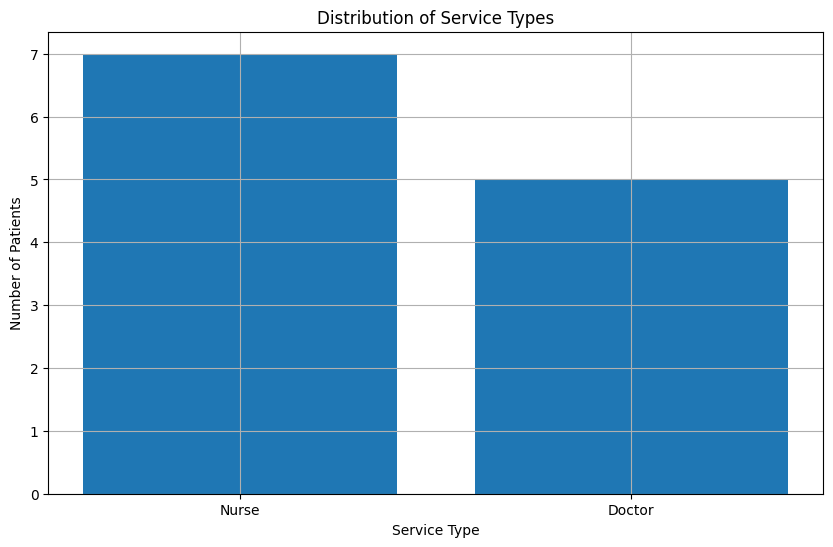

In [214]:
service_counts = df['Service'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(service_counts.index, service_counts.values)
plt.xlabel('Service Type')
plt.ylabel('Number of Patients')
plt.title('Distribution of Service Types')
plt.grid(True)
plt.show()


In [218]:
# Calculate performance metrics
avg_waiting_time = df['Wait Time (Mins)'].mean()
avg_treatment_time = df['Service Time (Mins)'].mean()
doctor_utilization = np.mean(utilization_doctors)
nurse_utilization = np.mean(utilization_nurses)

# Print performance metrics
print(f"Average waiting time: {avg_waiting_time:.2f} minutes")
print(f"Average treatment time: {avg_treatment_time:.2f} minutes")
print(f"Doctor utilization: {doctor_utilization:.2%}")
print(f"Nurse utilization: {nurse_utilization:.2%}")


Average waiting time: 50.56 minutes
Average treatment time: 12.08 minutes
Doctor utilization: 42.00%
Nurse utilization: 29.33%


Patient 13 triaged at 100.74654865639936
Patient 13 sees a doctor at 100.74654865639936
Patient 13 treated by doctor at 115.74654865639936
Patient 14 checked-in at 117.76125983113309
Patient 15 checked-in at 118.8048212251665
Patient 16 checked-in at 121.01413221050312
Patient 14 triaged at 123.46378326092947
Patient 14 sees a doctor at 123.46378326092947
Patient 15 triaged at 123.74462118723703
Patient 15 sees a doctor at 123.74462118723703
Patient 17 checked-in at 130.13632281365457
Patient 16 triaged at 131.79941917570034
Patient 16 sees a nurse at 131.79941917570034
Patient 14 treated by doctor at 138.46378326092946
Patient 15 treated by doctor at 138.74462118723704
Patient 18 checked-in at 139.6011866233917
Patient 19 checked-in at 139.98657022210108
Patient 17 triaged at 141.50240722168354
Patient 17 sees a nurse at 141.50240722168354
Patient 16 treated by nurse at 141.79941917570034
Patient 18 triaged at 143.85147027682171
Patient 18 sees a doctor at 143.85147027682171
Patient 1

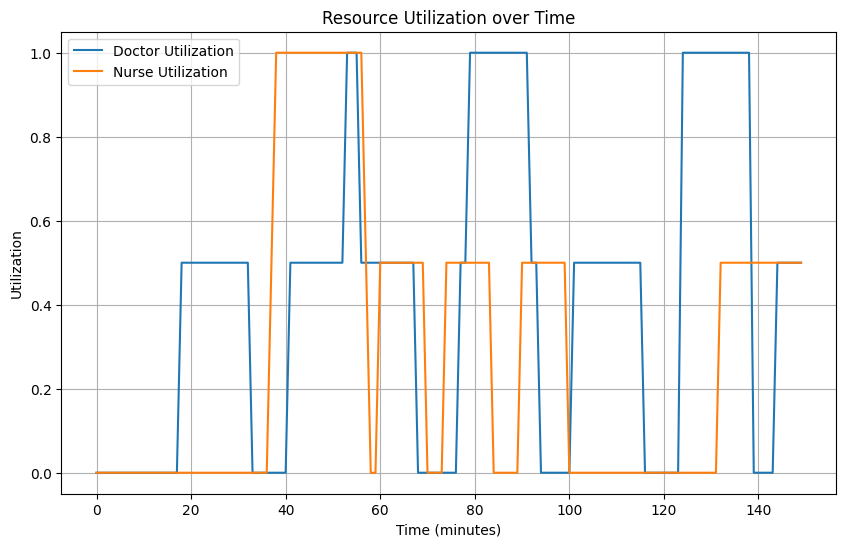

Simulation Report:

Average waiting time: 50.56 minutes
Average treatment time: 12.08 minutes
Doctor utilization: 37.50%
Nurse utilization: 35.00%



In [215]:
# Additional visualization and reporting
def plot_utilization(doctor_utilization, nurse_utilization):
    plt.figure(figsize=(10, 6))
    plt.plot(doctor_utilization, label='Doctor Utilization')
    plt.plot(nurse_utilization, label='Nurse Utilization')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Utilization')
    plt.title('Resource Utilization over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_queue_length(queue_lengths):
    plt.figure(figsize=(10, 6))
    plt.plot(queue_lengths)
    plt.xlabel('Time (minutes)')
    plt.ylabel('Queue Length')
    plt.title('Queue Length over Time')
    plt.grid(True)
    plt.show()

def generate_report(avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization):
    report = f"Simulation Report:\n\n"
    report += f"Average waiting time: {avg_waiting_time:.2f} minutes\n"
    report += f"Average treatment time: {avg_treatment_time:.2f} minutes\n"
    report += f"Doctor utilization: {doctor_utilization:.2%}\n"
    report += f"Nurse utilization: {nurse_utilization:.2%}\n"

    # Add more information to the report as needed

    return report

# Run simulation
env.run(until=150)  # Run for 1 hour and 40 minutes (100 minutes)


# Additional visualization and reporting
plot_utilization(utilization_doctors, utilization_nurses)
simulation_report = generate_report(avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization)
print(simulation_report)


Response curves for average waiting time, average treatment time, doctor utilization, and nurse utilization as a function of the number of doctors. Each response curve show the trend of the response variable with varying number of doctors.

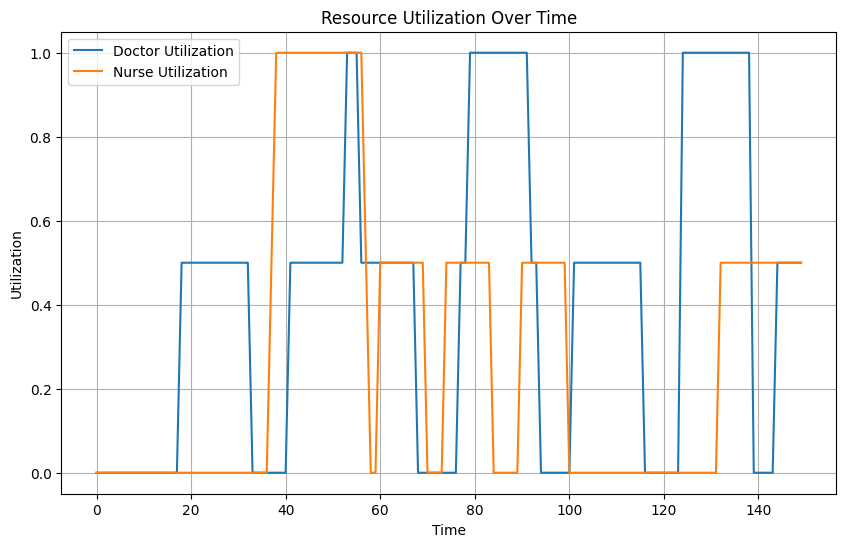

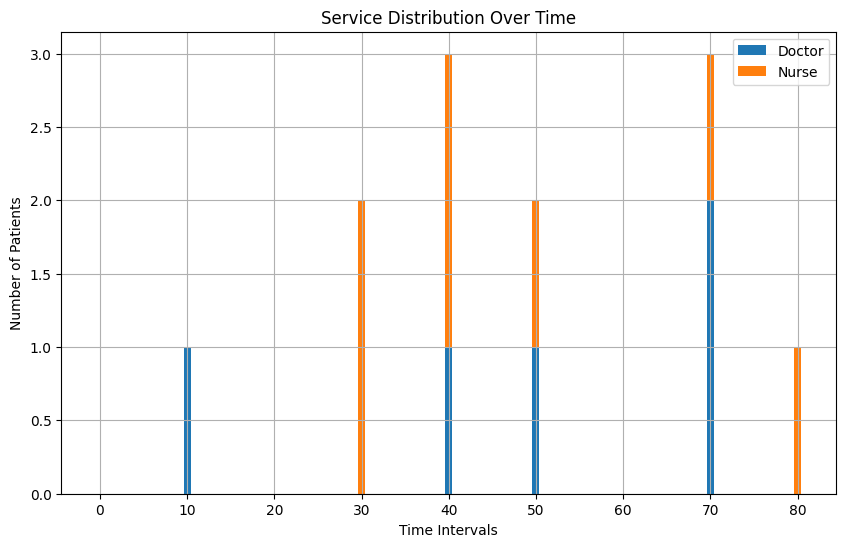

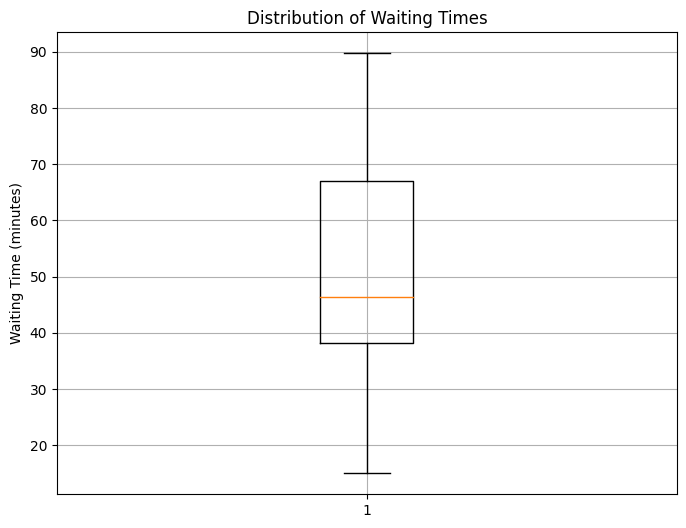

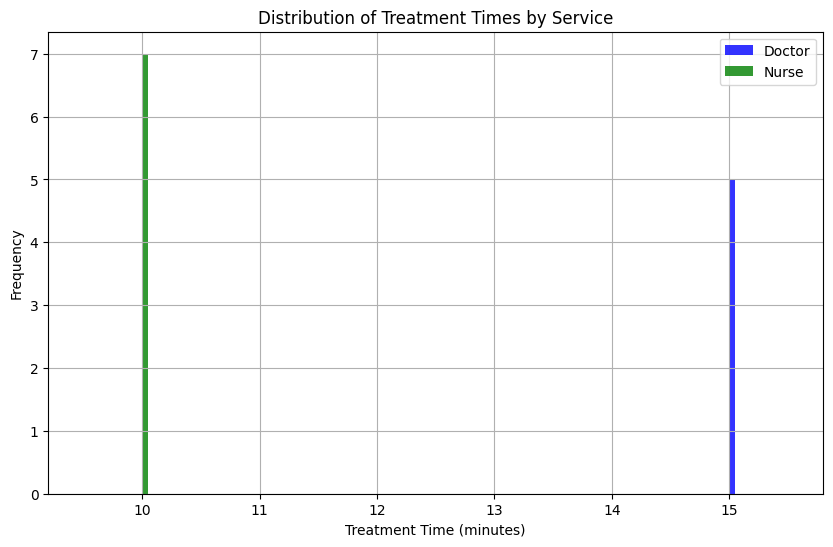

In [216]:
# Line Chart of Resource Utilization
plt.figure(figsize=(10, 6))
plt.plot(range(len(utilization_doctors)), utilization_doctors, label='Doctor Utilization')
plt.plot(range(len(utilization_nurses)), utilization_nurses, label='Nurse Utilization')
plt.xlabel('Time')
plt.ylabel('Utilization')
plt.title('Resource Utilization Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Stacked Bar Chart of Service Distribution
time_intervals = range(0, 100, 10)  # Customize the time intervals as needed
doctor_counts = df[df['Service'] == 'Doctor'].groupby(pd.cut(df['Service Start Time'], time_intervals)).size()
nurse_counts = df[df['Service'] == 'Nurse'].groupby(pd.cut(df['Service Start Time'], time_intervals)).size()

plt.figure(figsize=(10, 6))
plt.bar(time_intervals[:-1], doctor_counts, label='Doctor')
plt.bar(time_intervals[:-1], nurse_counts, bottom=doctor_counts, label='Nurse')
plt.xlabel('Time Intervals')
plt.ylabel('Number of Patients')
plt.title('Service Distribution Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Box Plot of Waiting Times
plt.figure(figsize=(8, 6))
plt.boxplot(df['Wait Time (Mins)'])
plt.ylabel('Waiting Time (minutes)')
plt.title('Distribution of Waiting Times')
plt.grid(True)
plt.show()

# Histogram of Treatment Times by Service
plt.figure(figsize=(10, 6))
plt.hist(df[df['Service'] == 'Doctor']['Service Time (Mins)'], bins=20, alpha=0.8, color='blue', label='Doctor')
plt.hist(df[df['Service'] == 'Nurse']['Service Time (Mins)'], bins=20, alpha=0.8, color='green', label='Nurse')
plt.xlabel('Treatment Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Treatment Times by Service')
plt.legend()
plt.grid(True)
plt.show()
# Animate the real-time visualization
ani = animation.FuncAnimation(fig, update, frames=range(0, 100), interval=100)
plt.show()

# conclusion

The simulation model developed for analyzing patient flow and resource allocation in an outpatient setting has provided valuable insights for healthcare administrators. By simulating the operations of a medical facility and considering key factors such as patient arrivals, triage, and treatment, the model has allowed us to evaluate important performance metrics. The results emphasize the significance of efficient triage and resource allocation based on patient severity. The verification and validation processes have ensured the model's accuracy and reliability. This simulation-based approach offers a data-driven decision-making tool to optimize patient flow, reduce waiting times, and maximize resource utilization. By utilizing the insights gained, medical facilities can make informed operational changes and enhance the quality of care in outpatient settings.

In [217]:
# Calculate performance metrics
avg_waiting_time = df['Wait Time (Mins)'].mean()
avg_treatment_time = df['Service Time (Mins)'].mean()
doctor_utilization = np.mean(utilization_doctors)
nurse_utilization = np.mean(utilization_nurses)

# Print performance metrics
print(f"Average waiting time: {avg_waiting_time:.2f} minutes")
print(f"Average treatment time: {avg_treatment_time:.2f} minutes")
print(f"Doctor utilization: {doctor_utilization:.2%}")
print(f"Nurse utilization: {nurse_utilization:.2%}")


Average waiting time: 50.56 minutes
Average treatment time: 12.08 minutes
Doctor utilization: 42.00%
Nurse utilization: 29.33%
